In [1]:
import os
import pickle
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.spatial import Delaunay
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import networkx as nx
from itertools import combinations
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:

def load_data(filepath: str) -> dict:
    """
    Load data from pickle file. The data is expected to be a dictionary:
    {node_identifier: pd.DataFrame with 'traffic_flow', 'Xkoordinat', 'Ykoordinat'}
    """
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    return data


def split_dataframes(df_dict: dict, train_ratio=0.7, val_ratio=0.1):
    """
    Splits the dictionary of DataFrames into train, validation, and test sets.
    Splits are done by time sequence.

    Args:
        df_dict: {node_key: pd.DataFrame}
        train_ratio: fraction of data for training
        val_ratio: fraction of data for validation

    Returns:
        df_dict_train, df_dict_val, df_dict_test
    """
    df_dict_train, df_dict_val, df_dict_test = {}, {}, {}
    for key, df in df_dict.items():
        n = len(df)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
        df_train = df.iloc[:train_end].copy()
        df_val = df.iloc[train_end:val_end].copy()
        df_test = df.iloc[val_end:].copy()

        df_dict_train[key] = df_train
        df_dict_val[key] = df_val
        df_dict_test[key] = df_test

    return df_dict_train, df_dict_val, df_dict_test


def create_sliding_window_data(df_dict: dict, lookback: int, pred_horizon: int):
    """
    Create sliding windows for each node.
    Returns {node: X_node}, {node: y_node}
    X_node shape: (#samples, lookback), y_node shape: (#samples, pred_horizon)
    """
    X_dict, y_dict = {}, {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node, y_node = [], []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i+lookback])
            y_node.append(node_series[i+lookback:i+lookback+pred_horizon])
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


def combine_node_data(X_dict: dict, y_dict: dict):
    """
    Combine data from all nodes into single arrays.
    """
    X_list = [X_dict[node] for node in X_dict]
    y_list = [y_dict[node] for node in y_dict]
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

In [3]:
def clean_graph(graph: nx.Graph) -> nx.Graph:
    """
    Clean the graph: remove self-loops, duplicate edges, keep largest component.
    """
    g = graph.copy()
    g.remove_edges_from(list(nx.selfloop_edges(g)))

    if len(g.nodes) > 0:
        largest_component = max(nx.connected_components(g), key=len)
        g = g.subgraph(largest_component).copy()

    return g

# =====================================================
#                   Graph Construction
# =====================================================

def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph where edges are based on spatial proximity.
    """
    graph = nx.Graph()
    coords = {}
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        coords[key] = (x, y)

    # Compute all pairwise distances
    keys = list(df_dict.keys())
    dist_list = []
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            x1, y1 = coords[k1]
            x2, y2 = coords[k2]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            dist_list.append((k1, k2, dist))

    # Sort edges by distance (ascending)
    dist_list.sort(key=lambda x: x[2])

    # Add edges while respecting degree constraints
    for k1, k2, dist in dist_list:
        if graph.degree[k1] < degree and graph.degree[k2] < degree:
            if weighted:
                # Normalize weights if desired
                graph.add_edge(k1, k2, weight=1/(1+dist))
            else:
                graph.add_edge(k1, k2)


    graph = clean_graph(graph)
    return graph


def create_delaunay_graph(df_dict):
    """
    Create a graph based on the Delaunay triangulation of spatial coordinates.

    Parameters:
        df_dict (dict): A dictionary where keys are node identifiers and values are
                        pandas DataFrames containing 'Xkoordinat' and 'Ykoordinat'.

    Returns:
        nx.Graph: A Delaunay graph where edges are formed from Delaunay triangulation.
    """
    # Initialize an empty graph
    graph = nx.Graph()

    # Extract node coordinates and their identifiers
    nodes = []
    coords = []
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        nodes.append(key)
        coords.append((x, y))

    # Perform Delaunay triangulation
    tri = Delaunay(coords)

    # Add edges from the Delaunay triangulation
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes[simplex[i]]
                node2 = nodes[simplex[j]]
                graph.add_edge(node1, node2)

    # Clean the graph (remove self-loops, keep largest connected component, etc.)
    graph = clean_graph(graph)

    return graph

def create_correlation_graph(df_dict_train, df_dict_full, threshold=0.5, weighted=False, degree=6):
    """
    Create a correlation-based graph using training data for correlation calculation.
    """
    graph = nx.Graph()
    keys = list(df_dict_full.keys())
    for key, df in df_dict_full.items():
        graph.add_node(key, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Compute correlation
    corr_matrix = {}
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys[i+1:], i+1):
            corr = np.corrcoef(df_dict_train[k1]['traffic_flow'], df_dict_train[k2]['traffic_flow'])[0, 1]
            corr_matrix[(k1, k2)] = corr
            corr_matrix[(k2, k1)] = corr

    # Sort edges by correlation
    for k1 in keys:
        potential = [(k2, corr_matrix[(k1, k2)]) for k2 in keys if k1 != k2 and (k1, k2) in corr_matrix]
        potential.sort(key=lambda x: -x[1])  # descending order by correlation
        for k2, c in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree and c > threshold:
                if weighted:
                    graph.add_edge(k1, k2, weight=c)
                else:
                    graph.add_edge(k1, k2)
    
    # find any nodes that are not connected to any other nodes, and connect
    graph = clean_graph(graph)
    return graph


def create_cosine_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph based on cosine similarity between full node time series.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    features = [df_dict[k]['traffic_flow'].values for k in keys]
    features = np.array(features)  # shape: (#nodes, #timesteps)
    # Compute cosine similarity
    norm = np.linalg.norm(features, axis=1, keepdims=True)
    normed = features / (norm + 1e-8)
    sim_matrix = normed @ normed.T  # cosine similarity

    for i, k1 in enumerate(keys):
        graph.add_node(k1,
                       x=df_dict[k1]['Xkoordinat'].iloc[0],
                       y=df_dict[k1]['Ykoordinat'].iloc[0],
                       traffic_flow=df_dict[k1]['traffic_flow'].values)

    # Sort by similarity
    for i, k1 in enumerate(keys):
        potential = [(keys[j], sim_matrix[i, j]) for j in range(len(keys)) if i != j]
        potential.sort(key=lambda x: -x[1])
        for k2, sim_val in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree:
                if weighted:
                    graph.add_edge(k1, k2, weight=sim_val)
                else:
                    graph.add_edge(k1, k2)
    graph = clean_graph(graph)
    return graph


def create_fully_connected_graph(df_dict, weighted=False):
    """
    Create a fully connected graph. Optionally assign random weights.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            if weighted:
                graph.add_edge(k1, k2, weight=np.random.rand())
            else:
                graph.add_edge(k1, k2)
    graph = clean_graph(graph)
    return graph


def create_dynamic_weight_graph(df_dict, lookback, pred_horizon, adaptive_factor=1.0, max_degree=4):
    """
    Create a graph with dynamic weights based on correlation of sliding windows.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Precompute sliding windows
    sliding_windows = {
        k: np.lib.stride_tricks.sliding_window_view(df_dict[k]['traffic_flow'].values, lookback)[:-pred_horizon]
        for k in keys
    }

    # Compute avg correlation over time for each pair
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            w1 = sliding_windows[k1]
            w2 = sliding_windows[k2]
            # correlation per window
            corrs = []
            for t in range(min(len(w1), len(w2))):
                if np.std(w1[t]) > 0 and np.std(w2[t]) > 0:
                    c = np.corrcoef(w1[t], w2[t])[0, 1]
                    corrs.append(c)
            if len(corrs) > 0:
                avg_weight = np.mean(corrs)
                threshold = adaptive_factor * avg_weight
                if avg_weight > threshold:
                    graph.add_edge(k1, k2, weight=avg_weight)

    # Enforce max degree
    for node in list(graph.nodes()):
        edges = sorted(graph.edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
        if len(edges) > max_degree:
            for edge in edges[max_degree:]:
                graph.remove_edge(edge[0], edge[1])

    graph = clean_graph(graph)
    return graph


def TOTAL_RANDOM_WEIGHTS(df_dict, degrees=32):
    # Initialize a graph
    num_nodes = len(df_dict)
    graph = nx.Graph()

    # Add nodes with attributes
    for i, (key, df) in enumerate(df_dict.items()):
        graph.add_node(i, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0], traffic_flow=df['traffic_flow'].values)

    # Randomly add edges while respecting degree constraints
    nodes = list(graph.nodes)
    max_attempts = num_nodes * degrees * 10  # Safety limit to prevent infinite loops
    attempts = 0

    while any(graph.degree(n) < degrees for n in nodes):
        u, v = np.random.choice(nodes, size=2, replace=False)
        # Add an edge only if it doesn't exist and both nodes are under degree limit
        if not graph.has_edge(u, v) and graph.degree(u) < degrees and graph.degree(v) < degrees:
            graph.add_edge(u, v, weight=np.random.rand())
        
        attempts += 1
        if attempts >= max_attempts:
            print("Warning: Maximum attempts reached, stopping early.")
            break

    # Return the graph and edge weights
    return graph, nx.get_edge_attributes(graph, 'weight')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# =====================================================
#                   General Decoder
# =====================================================
class GeneralMLPDecoder(nn.Module):
    """
    General Decoder for reconstructing node features.
    """
    def __init__(self, latent_dim, hidden_dim, out_dim):
        super(GeneralMLPDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, out_dim)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, z):
        x = F.relu(self.fc1(z))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class GeneralGraphAutoEncoder(nn.Module):
    """
    General Autoencoder for Graph Data: Encodes node features to latent space
    and decodes them to reconstruct the original features.
    """
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super(GeneralGraphAutoEncoder, self).__init__()
        # Encoder: GCN layers
        self.encoder1 = GCNConv(in_channels, hidden_channels)
        self.encoder2 = GCNConv(hidden_channels, latent_channels)
        self.dropout = nn.Dropout(p=0.3)
        # Decoder: MLP for node-level reconstruction
        self.decoder = GeneralMLPDecoder(latent_channels, hidden_channels, in_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Encoder
        x = F.relu(self.encoder1(x, edge_index))
        x = self.dropout(x)
        z = F.normalize(self.encoder2(x, edge_index), p=2, dim=1)  # Latent space embeddings
        # Decoder
        recon_features = self.decoder(z)  # Reconstruct node features
        return z, recon_features


# =====================================================
#                   Traffic Predictor
# =====================================================
class TrafficPredictor(nn.Module):
    """
    Traffic prediction model using node embeddings and temporal features.
    """
    def __init__(self, embedding_dim, temporal_dim, hidden_dim, output_dim):
        super(TrafficPredictor, self).__init__()
        self.fc1 = nn.Linear(embedding_dim + temporal_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, combined_features):
        x = F.relu(self.fc1(combined_features))
        x = self.dropout(x)
        return self.fc2(x)


# =====================================================
#                   Training GAE
# =====================================================
def train_general_gae(model, data, epochs, lr, device):
    """
    Train the Graph Autoencoder.
    """
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        z, recon_features = model(data)

        # Reconstruction loss
        loss = criterion(recon_features, data.x)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model


# =====================================================
#                   Training Predictor
# =====================================================
def train_traffic_predictor(model, embeddings, temporal_features, targets, epochs, lr, device):
    """
    Train the traffic flow predictor using node embeddings and temporal features.
    """
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        combined_features = torch.cat([embeddings, temporal_features], dim=1)
        preds = model(combined_features)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return model


# =====================================================
#                   Evaluation
# =====================================================
def evaluate_model(model, embeddings, temporal_features, targets):
    """
    Evaluate the traffic flow predictor on test data.
    """
    model.eval()
    with torch.no_grad():
        combined_features = torch.cat([embeddings, temporal_features], dim=1)
        preds = model(combined_features)
        mse = mean_squared_error(targets.cpu(), preds.cpu())
        mae = mean_absolute_error(targets.cpu(), preds.cpu())
    return mse, mae, preds


# =====================================================
#                   Main Workflow
# =====================================================
# Load data (assume preprocessed data)
DATA_PATH = 'data_prep/one_year.pkl'  # Adjust your path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume `load_data`, `split_dataframes`, `create_sliding_window_data`, and `combine_node_data` are implemented
final_dataframes = load_data(DATA_PATH)
df_dict_train, df_dict_val, df_dict_test = split_dataframes(final_dataframes, train_ratio=0.6, val_ratio=0.2)

LOOKBACK = 50
PRED_HORIZON = 1
HIDDEN_CHANNELS = 64
LATENT_CHANNELS = 32
EPOCHS_GAE = 1000
EPOCHS_PREDICTOR = 4000
LR_GAE = 1e-3

# Create sliding window data
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, LOOKBACK, PRED_HORIZON)
X_val_dict, y_val_dict = create_sliding_window_data(df_dict_val, LOOKBACK, PRED_HORIZON)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, LOOKBACK, PRED_HORIZON)

# Combine data
X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
X_val, y_val = combine_node_data(X_val_dict, y_val_dict)
X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

# Normalize features
scaler = StandardScaler()
X_train_normalized = torch.tensor(
    scaler.fit_transform(X_train), dtype=torch.float, device=device
)
X_val_normalized = torch.tensor(
    scaler.transform(X_val), dtype=torch.float, device=device
)
X_test_normalized = torch.tensor(
    scaler.transform(X_test), dtype=torch.float, device=device
)


# Prepare target tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)


In [ ]:
# Create graph
graph = create_distance_graph(final_dataframes, weighted=True, degree=6)

node_mapping = {node: i for i, node in enumerate(graph.nodes())}
edge_index = torch.tensor(
    [[node_mapping[u], node_mapping[v]] for u, v in graph.edges()],
    dtype=torch.long, device=device
).t().contiguous()
data = Data(x=X_train_normalized, edge_index=edge_index, num_nodes=len(graph.nodes))
LR_GAE = 0.000001
# Step 1: Train GAE
gae_model = GeneralGraphAutoEncoder(in_channels=LOOKBACK, hidden_channels=HIDDEN_CHANNELS, latent_channels=LATENT_CHANNELS)
gae_model = train_general_gae(gae_model, data, EPOCHS_GAE+10000, LR_GAE, device)

Epoch 0, Loss: 0.0187
Epoch 1, Loss: 0.0188
Epoch 2, Loss: 0.0187
Epoch 3, Loss: 0.0188
Epoch 4, Loss: 0.0187
Epoch 5, Loss: 0.0188
Epoch 6, Loss: 0.0187
Epoch 7, Loss: 0.0187
Epoch 8, Loss: 0.0188
Epoch 9, Loss: 0.0187
Epoch 10, Loss: 0.0187
Epoch 11, Loss: 0.0187
Epoch 12, Loss: 0.0187
Epoch 13, Loss: 0.0187
Epoch 14, Loss: 0.0187
Epoch 15, Loss: 0.0188
Epoch 16, Loss: 0.0187
Epoch 17, Loss: 0.0187
Epoch 18, Loss: 0.0187
Epoch 19, Loss: 0.0188
Epoch 20, Loss: 0.0188
Epoch 21, Loss: 0.0188
Epoch 22, Loss: 0.0188
Epoch 23, Loss: 0.0188
Epoch 24, Loss: 0.0187
Epoch 25, Loss: 0.0188
Epoch 26, Loss: 0.0188
Epoch 27, Loss: 0.0188
Epoch 28, Loss: 0.0188
Epoch 29, Loss: 0.0187
Epoch 30, Loss: 0.0188
Epoch 31, Loss: 0.0187
Epoch 32, Loss: 0.0187
Epoch 33, Loss: 0.0188
Epoch 34, Loss: 0.0188
Epoch 35, Loss: 0.0187
Epoch 36, Loss: 0.0187
Epoch 37, Loss: 0.0188
Epoch 38, Loss: 0.0187


KeyboardInterrupt: 

In [ ]:
# Show its reconstruction performance
new_data = Data(x=X_test_normalized, edge_index=edge_index, num_nodes=len(graph.nodes))
_, recon_features = gae_model(new_data)
recon_loss = F.mse_loss(recon_features, new_data.x)
print(f"Reconstruction Loss: {recon_loss.item():.4f}")


Reconstruction Loss: 0.0243


In [ ]:
# Step 2: Extract Embeddings
gae_model.eval()
with torch.no_grad():
    embeddings, _ = gae_model(data)

embeddings

tensor([[ 0.0478,  0.1939, -0.2752,  ...,  0.1779,  0.1339,  0.1988],
        [ 0.0045,  0.1996, -0.2855,  ...,  0.1583,  0.1112,  0.1673],
        [ 0.0407,  0.2010, -0.2804,  ...,  0.1655,  0.0954,  0.1749],
        ...,
        [ 0.0706,  0.1991, -0.2422,  ...,  0.1274,  0.1844,  0.1277],
        [ 0.0711,  0.2002, -0.2443,  ...,  0.1281,  0.1867,  0.1275],
        [ 0.0710,  0.2002, -0.2453,  ...,  0.1301,  0.1862,  0.1258]],
       device='cuda:0')

In [ ]:
# Step 3: Extract Embeddings for Train, Validation, and Test Sets
gae_model.eval()
with torch.no_grad():
    train_embeddings, _ = gae_model(Data(x=X_train_normalized, edge_index=edge_index, num_nodes=len(graph.nodes)))
    val_embeddings, _ = gae_model(Data(x=X_val_normalized, edge_index=edge_index, num_nodes=len(graph.nodes)))
    test_embeddings, _ = gae_model(Data(x=X_test_normalized, edge_index=edge_index, num_nodes=len(graph.nodes)))
LR_PREDICTOR = 1e-8
# Step 4: Train Traffic Predictor
predictor = TrafficPredictor(embedding_dim=LATENT_CHANNELS, temporal_dim=LOOKBACK, hidden_dim=64, output_dim=PRED_HORIZON)
predictor = train_traffic_predictor(predictor, train_embeddings, X_train_normalized, y_train_tensor, EPOCHS_PREDICTOR+2000, LR_PREDICTOR, device)

# Step 5: Evaluate
mse, mae, preds = evaluate_model(predictor, test_embeddings, X_test_normalized, y_test_tensor)
# calculate vape and mape
vape = np.mean(np.abs(y_test - preds.cpu().numpy()))
mape = np.mean(np.abs(y_test - preds.cpu().numpy())/y_test)
print(f"Test MSE: {mse:.4f}, Test MAE: {mae:.4f} ")

Epoch 0, Loss: 673.9866
Epoch 10, Loss: 670.1482
Epoch 20, Loss: 669.7883
Epoch 30, Loss: 671.2095
Epoch 40, Loss: 675.8441
Epoch 50, Loss: 679.3771
Epoch 60, Loss: 675.6426
Epoch 70, Loss: 674.0076
Epoch 80, Loss: 670.7828
Epoch 90, Loss: 674.1289
Epoch 100, Loss: 671.7686
Epoch 110, Loss: 671.2534
Epoch 120, Loss: 671.4061
Epoch 130, Loss: 676.5117
Epoch 140, Loss: 672.3400
Epoch 150, Loss: 671.6749
Epoch 160, Loss: 674.4751
Epoch 170, Loss: 677.1050
Epoch 180, Loss: 672.7474
Epoch 190, Loss: 669.2577
Epoch 200, Loss: 664.8359
Epoch 210, Loss: 665.5192
Epoch 220, Loss: 672.8985
Epoch 230, Loss: 672.3962
Epoch 240, Loss: 676.4595
Epoch 250, Loss: 679.8393
Epoch 260, Loss: 674.3388
Epoch 270, Loss: 668.6106
Epoch 280, Loss: 678.7165
Epoch 290, Loss: 675.5907
Epoch 300, Loss: 678.0082
Epoch 310, Loss: 672.2331
Epoch 320, Loss: 672.6443
Epoch 330, Loss: 668.9522
Epoch 340, Loss: 669.8717
Epoch 350, Loss: 672.3152
Epoch 360, Loss: 678.0271
Epoch 370, Loss: 674.6748
Epoch 380, Loss: 662.56

KeyboardInterrupt: 

In [16]:
mse, mae, preds = evaluate_model(predictor, test_embeddings, X_test_normalized, y_test_tensor)
# calculate vape and mape
vape = np.mean(np.abs(y_test - preds.cpu().numpy()))
mape = np.mean(np.abs(y_test - preds.cpu().numpy())/(y_test+0.0000001))
print(f"Test MSE: {mse:.4f}, Test MAE: {mae:.4f} Vape {vape} Mape {mape}")

Test MSE: 297.3530, Test MAE: 8.8711 Vape 8.871095859638721 Mape 2280565.9038969465


In [18]:
torch.save(gae_model.state_dict(), 'model.pth')

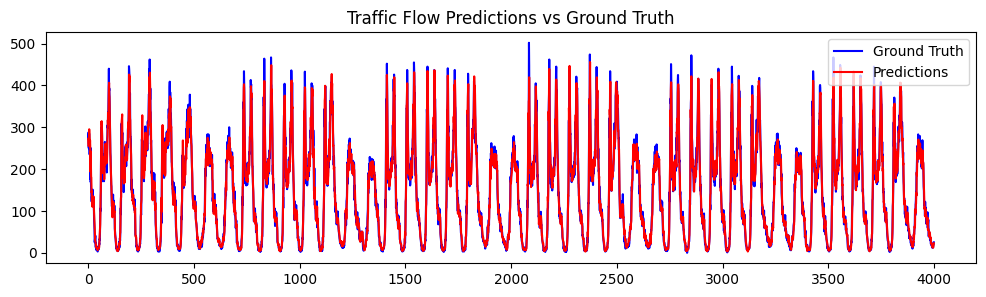

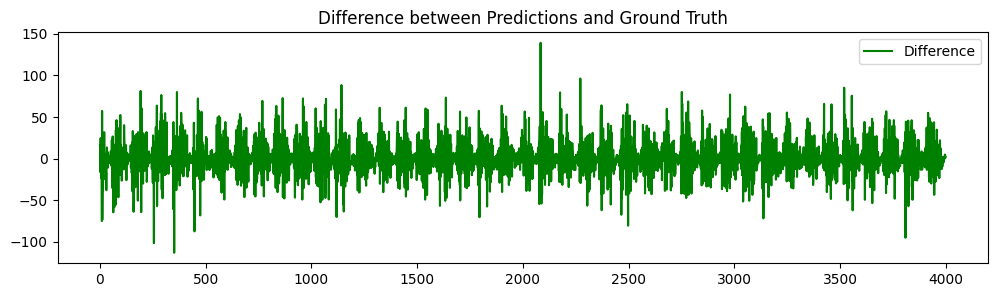

In [ ]:
# Plot predictions vs ground truth
plt.figure(figsize=(12, 3))
plt.plot(y_test[0:4000], label='Ground Truth', color='blue')
plt.plot(preds.cpu().numpy()[0:4000], label='Predictions', color='red')
plt.legend()
plt.title("Traffic Flow Predictions vs Ground Truth")
plt.show()

# plot difference
plt.figure(figsize=(12, 3))
plt.plot(y_test[0:4000] - preds.cpu().numpy()[0:4000], label='Difference', color='green')
plt.legend()
plt.title("Difference between Predictions and Ground Truth")
plt.show()


In [ ]:
results = {}

# Load pre-trained GAE
gae_model = GeneralGraphAutoEncoder(in_channels=LOOKBACK, hidden_channels=HIDDEN_CHANNELS, latent_channels=LATENT_CHANNELS)
gae_model.load_state_dict(torch.load("gae_model.pth", map_location=device))
gae_model.to(device)
gae_model.eval()

for model_name, graph_fn in graph_models.items():
    print(f"Processing graph: {model_name}")
    
    # Create the graph
    graph = graph_fn()
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    edge_index = torch.tensor(
        [[node_mapping[u], node_mapping[v]] for u, v in graph.edges()],
        dtype=torch.long, device=device
    ).t().contiguous()

    # Prepare graph data
    graph_data = Data(x=X_train_normalized, edge_index=edge_index, num_nodes=len(graph.nodes))

    # Step 1: Extract embeddings using GAE
    with torch.no_grad():
        embeddings, _ = gae_model(graph_data)

    # Step 2: Train traffic predictor
    predictor = TrafficPredictor(
        embedding_dim=LATENT_CHANNELS, 
        temporal_dim=LOOKBACK, 
        hidden_dim=64, 
        output_dim=PRED_HORIZON
    ).to(device)

    predictor = train_traffic_predictor(
        predictor, 
        embeddings, 
        X_train_normalized, 
        y_train_tensor, 
        epochs=300, 
        lr=1e-3, 
        device=device
    )

    # Step 3: Evaluate the predictor
    mse, mae, preds = evaluate_model(predictor, embeddings, X_test_normalized, y_test_tensor)

    # Store results
    results[model_name] = {
        "test_mse": mse,
        "test_mae": mae,
        "predictions": preds.cpu().numpy(),
        "actuals": y_test_tensor.cpu().numpy()
    }

# Print summary
print("======================== SUMMARY ========================")
for model_name, res in results.items():
    print(f"Graph: {model_name}, Test MSE: {res['test_mse']:.4f}, Test MAE: {res['test_mae']:.4f}")
